In [1]:
# -*- coding: utf-8 -*-
import time
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import classification_report

c:\Users\Davidgu\anaconda3\envs\tensorflow-cpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# label : 1 表示 failed ; -1 表示 normal
def get_data_from_txt(filename):
    labels = []
    data = []
    with open(filename, 'r') as f:
        for line in f:
            _line = line.strip('\n').strip(' ').split('  ') #每個資料中間兩個空格
            # 標籤映射 -1 ~ 1 變成 0 ~ 1
            _label = float(_line[0])
            _label = int((_label + 1) / 2)
            labels.append(_label)
            data.append([float(i) for i in _line[1:]])
    return np.array(data), np.array(labels)
        

In [3]:
train_filename = "FordA/FordA_TRAIN.txt"
X_train, y_train = get_data_from_txt(train_filename)
print(f"X_train.shape: {X_train.shape}, y_train.length: {len(y_train)}")

test_filename = "FordA/FordA_TEST.txt"
X_test, y_test = get_data_from_txt(test_filename)
print(f"X_test.shape: {X_test.shape}, y_test.length: {len(y_test)}")

X_train.shape: (3601, 500), y_train.length: 3601
X_test.shape: (1320, 500), y_test.length: 1320


In [4]:
# 驗證數值正確性
print(y_train[0])
print(X_train[0,:20])

0
[-0.79717168 -0.66439208 -0.37301463  0.04081512  0.52693599  0.98428794
  1.3531202   1.5781078   1.6592509   1.6408093   1.5522896   1.4379516
  1.2793537   1.0691193   0.744547    0.27760541 -0.30072351 -0.93732792
 -1.5200828  -1.9516165 ]


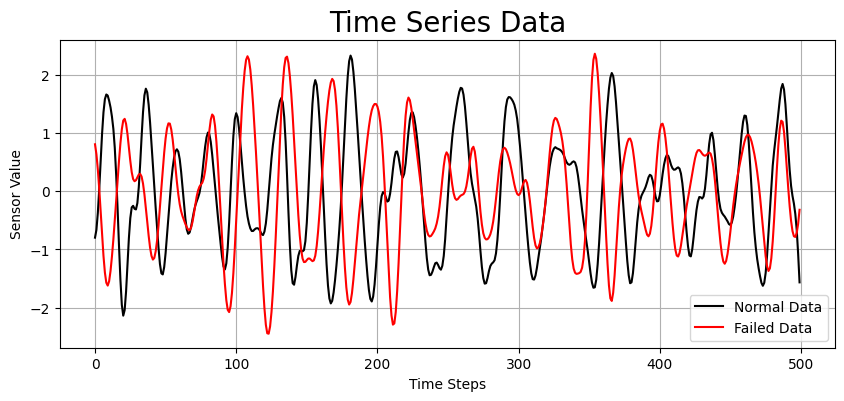

In [5]:
# plot failed and normal data
# UCR/UEA 版本的 Ford A 資料集在釋出前就已經對 每一條序列做過 z-score 標準化——也就是「該序列的平均值 = 0、標準差 = 1」
plt.figure(figsize=(10, 4))
plt.grid(True)
plt.xlabel('Time Steps')
plt.ylabel('Sensor Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(X_train[0,:], label='Normal Data',c='black')
plt.plot(X_train[1,:], label='Failed Data', c='red')
plt.legend(fontsize=10)
plt.show()

In [6]:
# reshape 為 (samples, timesteps, channels)
X_train = X_train[..., np.newaxis]
X_test  = X_test[...,  np.newaxis]

print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")


# reshape 為原本 0 → [1, 0]; 原本 1 → [0, 1]
y_train = to_categorical(y_train, num_classes=2)
y_test  = to_categorical(y_test,  num_classes=2)

print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (3601, 500, 1)
X_test.shape: (1320, 500, 1)
y_train.shape: (3601, 2)
y_test.shape: (1320, 2)


In [ ]:
# 建立簡化版FCN模型, 參考: https://keras.io/examples/timeseries/timeseries_classification_from_scratch/?utm_source=chatgpt.com
def build_model(input_shape, num_classes=2):
    input_layer  = tf.keras.Input(shape=input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    gap = tf.keras.layers.GlobalAveragePooling1D()(conv3)
    
    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(gap)
    
    return tf.keras.Model(inputs=input_layer, outputs=output_layer, name="FordA_1DCNN")

In [8]:
model = build_model(X_train.shape[1:], 2)
model.summary()

Model: "FordA_1DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 500, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,858 (101.01 KB)

 Trainable params: 25,474 (99.51 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# 編譯與訓練
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss="categorical_crossentropy", # sparse_categorical_crossentropy for keras
    metrics=["accuracy"], # sparse_categorical_accuracy for keras
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "./checkpoints/cls_1dcnn/best_1dcnn_forda_0623.keras", save_best_only=True, monitor="val_loss"
    ),
    # tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    # ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=50, verbose=1
    )
]

#訓練
ts = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=32,
    callbacks=callbacks,
    verbose=1,
)

te = time.time()
print("\n time cost for training: %.2f sec" % (te-ts))

Epoch 1/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5572 - loss: 0.7294 - val_accuracy: 0.5159 - val_loss: 0.6911
Epoch 2/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6869 - loss: 0.6107 - val_accuracy: 0.4841 - val_loss: 0.6973
Epoch 3/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7154 - loss: 0.5609 - val_accuracy: 0.4841 - val_loss: 0.6993
Epoch 4/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7323 - loss: 0.5245 - val_accuracy: 0.4886 - val_loss: 0.6869
Epoch 5/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7616 - loss: 0.4825 - val_accuracy: 0.6356 - val_loss: 0.6151
Epoch 6/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7629 - loss: 0.4801 - val_accuracy: 0.6992 - val_loss: 0.5053
Epoch 7/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7531 - loss: 0.4622 - val_accuracy: 0.7682 - val_loss: 0.4367
Epoch 8/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7922 - loss: 0.4453 - 

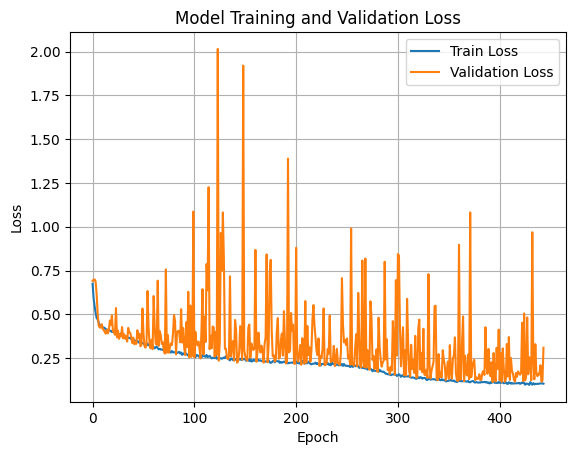

In [10]:
#繪製loss trend
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

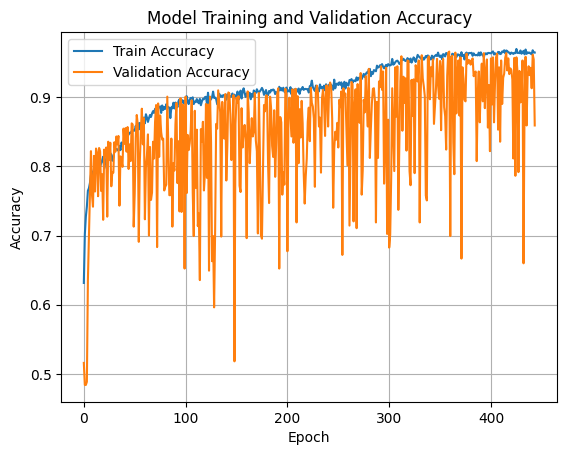

In [11]:
#繪製acc trend
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
# 評估
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.6f}")

print(f"Train accuracy: {train_acc:.4f}")
print(f"Train loss: {train_loss:.6}")

#計算train loss and valid loss誤差百分比, > 3~5% 有可能為過擬合
train_test_acc_diff = abs(train_acc - test_acc)
percentage = (train_test_acc_diff / train_acc) * 100
print(f"Train and Test Acc. difference percentage: {percentage:.2f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9646 - loss: 0.1126
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9690 - loss: 0.0951
Test accuracy: 0.9636
Test loss: 0.113235
Train accuracy: 0.9667
Train loss: 0.101539
Train and Test Acc. difference percentage: 0.31


# 更詳細報告
| 欄位                  | 含意                                      | 計算方式（以「正類」為例）       |
| ------------------- | --------------------------------------- | ------------------- |
| **precision**（精確率）  | 在所有被模型預測為「正類」的樣本裡，實際上真的是正類的比例。          | TP / (TP + FP)      |
| **recall**（召回率、靈敏度） | 在所有實際為「正類」的樣本中，被模型成功抓到的比例。              | TP / (TP + FN)      |
| **f1-score**        | precision 與 recall 的調和平均，兼顧「抓得準」與「抓得到」。 | 2 x (p x r)/(p + r) |
| **support**         | 該類別在 *y_test* 中出現的樣本數（資料量）。            | —                   |


In [ ]:
# 評估
y_pred = model.predict(X_test)
_y_pred = np.argmax(y_pred, axis=1)
_y_test = np.argmax(y_test, axis=1)
print(classification_report(_y_test, _y_pred, digits=4))

'''
與keras官方公布簡版 FCN的結果 acc = 0.95 ~ 0.97誤差 0.6%
'''

              precision    recall  f1-score   support

           0     0.9515    0.9794    0.9653       681
           1     0.9774    0.9468    0.9618       639

    accuracy                         0.9636      1320
   macro avg     0.9644    0.9631    0.9636      1320
weighted avg     0.9640    0.9636    0.9636      1320



y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred[:5])
print(y_test.shape)
print(y_test[:5])

In [ ]:
# 非量化轉換(保留原模型大小)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_no_quantized = converter.convert()

with open("./checkpoints/cls_1dcnn/final_1dcnn_forda_0623.tflite", "wb") as f:
    f.write(tflite_model_no_quantized)

INFO:tensorflow:Assets written to: C:\Users\Davidgu\AppData\Local\Temp\tmp8524a8o9\assets


INFO:tensorflow:Assets written to: C:\Users\Davidgu\AppData\Local\Temp\tmp8524a8o9\assets


Saved artifact at 'C:\Users\Davidgu\AppData\Local\Temp\tmp8524a8o9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 500, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2222219481104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2222219481680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2222219482640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2222219481488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2222219481296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2222219483600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2222219483024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2222219482256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2222219484560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2222219484752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22222194